# A short demo of PyArrow & Neo4j 😀
<img src="https://arrow.apache.org/docs/_static/arrow.png" style="width:200px;">

## Our Dependencies
Nothing special really...the usual cast of characters with the addition of `pyarrow`

In [1]:
%pip install pyarrow pandas scikit-learn matplotlib seaborn
%matplotlib inline

You should consider upgrading via the '/home/dave/jupyter/venv/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


### Imports and our Integration
We'll set up our imports next.

One special import is [neo4j_arrow](https://gist.github.com/voutilad/ac1107a383affcdfdaaf4a08d1f14df4), the client wrapper to simplify talking to the server-side `Neo4j-Arrow` service. It's like **100 lines of Python** and uses the `PyArrow` framework...no Neo4j code!

> Server-side it exists as a database plugin. If you have access, the code is here: https://github.com/neo4j-field/neo4j-arrow

In [2]:
# Get our DS imports ready!
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# To time stuff...
import time

# And our neo4j integration!
import neo4j_arrow

---

## Connecting our Neo4jArrow Client
Very simple. We provide access credentials (username, password) and then provide the location of the server in a tuple of `(host, port)`.

`Neo4jArrow` uses Neo4j's built-in authorization framework. All our calls to the server are authenticated like any other Neo4j client.

In [3]:
client = neo4j_arrow.Neo4jArrow('neo4j', 'password',
                                ('voutila-arrow-test', 9999),
                                tls=True, verify_tls=False)

### Discovering Available Actions
Arrow Flight uses an RPC concept. In short, clients can perform _Actions_ sending optional payload data to the server with each action. Clients can also consume or put _streams_ to/from the server.

Let's discover our available actions!

In [4]:
actions = client.list_actions()

for action in actions:
  print(action)

ActionType(type='cypherRead', description='Submit a new Cypher-based read job')
ActionType(type='cypherWrite', description='Submit a new Cypher-based write job')
ActionType(type='jobStatus', description='Check the status of a Job')
ActionType(type='gds.read', description='Stream node or relationship properties from a GDS Graph')
ActionType(type='gds.write.relationships', description='Write relationship properties to a GDS Graph')
ActionType(type='gds.write.nodes', description='Write Nodes and properties to a GDS Graph')


Each of these actions can be called by an Apache Arrow client, regardless if it's PyArrow or the Arrow R package or Arrow for Rust!

---

## Working with Cypher Jobs
The way I've architected `Neo4jArrow` is designed around submitting "jobs" that construct streams. Let's submit some Cypher!

> Note: Cypher jobs are orders of magnitude _slower_ than GDS jobs...but still faster than
> using a Neo4j Python driver by an order of magnitude!

In [5]:
cypher = """
UNWIND range(1, $rows) AS row
RETURN row, [_ IN range(1, $dimension) | rand() ] AS n;
"""
params = {
    "rows": 1_000_000,
    "dimension": 256
}

print(f"Submitting cypher with params:\n{cypher}\n{params}")

ticket = client.cypher(cypher, params=params)

print(f"Got a ticket: {ticket}")

Submitting cypher with params:

UNWIND range(1, $rows) AS row
RETURN row, [_ IN range(1, $dimension) | rand() ] AS n;

{'rows': 1000000, 'dimension': 256}
Got a ticket: <Ticket b'f142903a-bca5-4836-9a06-aeda285a092b'>


### Waiting for our Results (Optional)
Each job results in a _ticket_. Clients use the ticket to check on job status or request a stream of the results.

Let's wait until our Cypher is producing results and our stream is ready for consumption. This little helper function just polls the `jobStatus` _Action_ waiting for our job to be in a "producing" state.

In [6]:
print(f'>> Polling for status on ticket {ticket}...')
ready = client.wait_for_job(ticket, timeout=35)
if not ready:
    raise Exception('something is wrong...did you submit a job?')
else:
    print('>> Stream is Ready!')

>> Polling for status on ticket <Ticket b'f142903a-bca5-4836-9a06-aeda285a092b'>...
>> Stream is Ready!


### Consuming our Results
Clients consume streams by presenting their ticket. They bet back a PyArrow stream reader and have some options to how they consume the stream:

1. They can iterate over batches in the stream and process them incrementally.
2. They can consume the entire stream into a PyArrow Table
3. They can consume the entire stream immediately into a Pandas data frame

In [7]:
# Let's get a dataframe!
print('>> Reading the result of our Cypher job into a dataframe. Please wait...')

start = time.time()
table = client.stream(ticket).read_all()
delta = round(time.time() - start, 1)

print(f'>> Read our stream entirely into a PyArrow table in {delta} seconds!')
print(table)
megs = table.nbytes >> 20

print(f"Table is approximately {megs:,} MiB")

>> Reading the result of our Cypher job into a dataframe. Please wait...
>> Read our stream entirely into a PyArrow table in 16.8 seconds!
pyarrow.Table
row: int64
n: fixed_size_list<n: double>[256]
  child 0, n: double
Table is approximately 1,960 MiB


#### Let's Work with Pandas and Scikit-Learn!

In [8]:
# We'll convert our series of embedding arrays into a NumPy matrix
print(">> Converting to a Pandas DataFrame...")
df = table.select(['n'])[0].to_pandas()

print(">> Building a NumPy matrix...")
m = np.matrix(df.tolist())

# Then let's do dimensional reduction so we can plot our vectors
pca = PCA(n_components=2)
print(">> Fitting PCA transform...please wait!")
pc = pca.fit_transform(m)

print('>> Before, our data looked like :')
print(table.select(['n'])[0][0:1])

print('>> Now we have a matrix like:')
print(pc)

>> Converting to a Pandas DataFrame...
>> Building a NumPy matrix...
>> Fitting PCA transform...please wait!
>> Before, our data looked like :
[
  [
    [
      0.00834049,
      0.266981,
      0.515612,
      0.229485,
      0.649175,
      0.0850215,
      0.443056,
      0.0449929,
      0.0191804,
      0.399686,
      ...
      0.84188,
      0.135641,
      0.492096,
      0.684871,
      0.518024,
      0.457598,
      0.134486,
      0.578388,
      0.622118,
      0.190917
    ]
  ]
]
>> Now we have a matrix like:
[[-0.59041513 -0.40286136]
 [-0.25576433  0.16838446]
 [-0.34180623  0.51296398]
 ...
 [-0.11586365 -0.34161673]
 [-0.01363905 -0.06582818]
 [ 0.4771318   0.51684194]]


Let's plot!

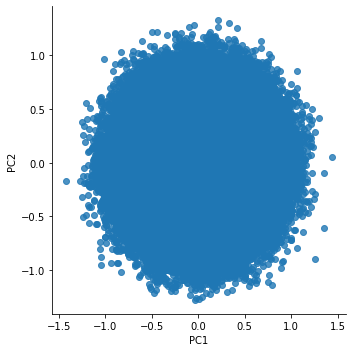

In [9]:
pc_df = pd.DataFrame(data=pc, columns=['PC1', 'PC2'])
sns.lmplot( x="PC1", y="PC2",
  data=pc_df,
  fit_reg=False)

---

## Now for the fun stuff: Direct GDS Integration!
We just played with Cypher, which is fine...but what about working with _even more data_ from things like GDS?

Our traditional methods using the Python driver would absolutely choke here...but with PyArrow, I can stay in my comfy little Python world and still get data _fast_.

### Submitting a GDS Job
We'll submit a GDS job that reads directly from the in-memory graph. In this case, it's analagous to something like:

```
CALL gds.graph.streamNodeProperties('random', ['fastRp'])
```

Suppose we already have a random graph with node embeddings built via something like:

```
CALL gds.beta.graph.generate('random', toInteger(5e6), 5);
CALL gds.fastRP.mutate('random', {
    embeddingDimension: 256,
    mutateProperty: 'fastRp'
});
```

> Note that this follows the same general flow as before: submit job, get ticket, get stream

In [10]:
# Submit our GDS job to retrieve some node embeddings from a graph projection
ticket = client.gds_nodes('random', properties=['fastRp'])
client.wait_for_job(ticket, timeout=15)

print('>> Reading the result of our GDS job...''')
start = time.time()

# Retrieve and consume the stream into a PyArrow Table
table = client.stream(ticket).read_all()
delta = round(time.time() - start, 2)
gigs, rows = round((table.nbytes >> 20) / 1024.0, 2), table.num_rows

print(f'>> Took {delta:,}s to consume stream into a PyArrow table.')
print(f'>> Table has {rows:,} rows, represents ~{gigs:,} GiB.')

# And convert to Pandas!
start = time.time()
df = table.to_pandas()
delta = round(time.time() - start, 2)

print(f'>> Built a Pandas DataFrame in {delta:,} seconds!')
print(df)


>> Reading the result of our GDS job...
>> Took 2.76s to consume stream into a PyArrow table.
>> Table has 1,000,000 rows, represents ~0.97 GiB.
>> Built a Pandas DataFrame in 1.55 seconds!
        _node_id_   _labels_  \
0           67585  [__ALL__]   
1           89857  [__ALL__]   
2          126977  [__ALL__]   
3           70659  [__ALL__]   
4           86551  [__ALL__]   
...           ...        ...   
999995     984085  [__ALL__]   
999996     984143  [__ALL__]   
999997     984201  [__ALL__]   
999998     984259  [__ALL__]   
999999     984317  [__ALL__]   

                                                   fastRp  
0       [0.08633894, 0.060462683, 0.15721866, 0.190311...  
1       [-0.119828455, -0.12914816, -0.04802876, -0.06...  
2       [-0.03208739, 0.20777702, 0.037908323, -0.0028...  
3       [0.080578744, -0.039490893, 0.015158851, 0.061...  
4       [0.042886402, 0.094128415, 0.114723094, -0.005...  
...                                                   ...  
99999

Now we'll do our little data conversion and PCA...

In [11]:
# Select out just our embedding vectors and convert it to a numpy matrix
m = np.matrix(df['fastRp'].tolist())

# Then let's do dimensional reduction so we can plot our vectors in a lower dimension
print('>> Performing dimensional reduction...please wait!')
pca = PCA(n_components=3)

print('>> Fitting transform...')
pc = pca.fit_transform(m)

print('>> Our new 3-dimensional vectors look like:')
print(pc)

>> Performing dimensional reduction...please wait!
>> Fitting transform...
>> Our new 3-dimensional vectors look like:
[[-0.0463969  -0.00391163  0.08510811]
 [-0.05758531 -0.14159386  0.04622212]
 [ 0.00386701 -0.07688583  0.05647824]
 ...
 [ 0.0579492  -0.01313278 -0.11065765]
 [ 0.02657844  0.02953728 -0.0188402 ]
 [ 0.13524081 -0.04771822 -0.05203478]]


And plot!

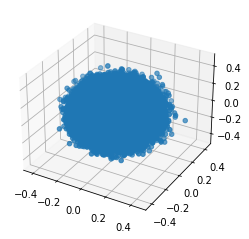

In [12]:
pc_df = pd.DataFrame(data=pc, columns=['PC1', 'PC2', 'PC3'])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pc_df['PC1'], pc_df['PC2'], pc_df['PC3'])
plt.show()

---

## Towards the Future 🚀

Other languages supported by Apache Arrow:
* R
* Matlab
* Julia
* and more!

Some ponderings:
* can we do better bulk updates/writes by moving data via Arrow to the server?
* how about replicating an entire in-memory graph to another Neo4j system?
* if we ditch the whole 2-step process (get ticket, get stream) how simple can our DX be?
